[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/EELSfitter/blob/documentation/tutorials/tutorial_eelsfitter.ipynb)

# EELSFitter tutorial

In this tutorial, we are going to train a model of the zero-loss peak (ZLP) background of polytopic WS$_2$ nanoflowers. Individiual spectra are first classified as a function of the local thickness with $K$-means clustering before serving as input to a feedforward neural network. 

The ZLP models can be used to obtain a ZLP-subtracted spectral image (SI), which in turn gives access to the dielectric function through the Kramers-Krönig analysis. One can also find the bandgap energy from the subtracted spectrum.

## Loading the SI

First of all, let us import the EELSFitter package:

In [1]:
import os
import numpy as np
import wget

import EELSFitter as ef
from EELSFitter.core.spectral_image import SpectralImage as spectim
from EELSFitter.plotting.zlp import plot_zlp_signal
from EELSFitter.plotting.heatmaps import plot_heatmap

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 12})
rc('text', usetex=True)

Next, we download and load the spectral image and specify the location where we would like to store our output, such as plots.

In [ ]:
dm4_url='https://github.com/LHCfitNikhef/EELSfitter/blob/documentation/tutorials/area03-eels-SI-aligned.dm4?raw=true'
wget.download(dm4_url)

In [2]:
dm4_path = "area03-eels-SI-aligned.dm4"
im = spectim.load_data(dm4_path)
im.output_path = os.path.join(os.getcwd(), 'output')

if not os.path.exists(im.output_path):
    os.mkdir(im.output_path)

The below specifies some of our plot settings:

In [3]:
cmap="coolwarm"
npix_xtick=26.25
npix_ytick=26.25
sig_ticks = 3
scale_ticks = 1E-3
tick_int = True

cb_scale=0.85
title_specimen = r'$\rm{WS_2\;nanoflower\;}$'
save_title_specimen = 'WS2_nanoflower_flake'
save_loc = im.output_path

im.e0       = 200                           # keV
im.beta     = 67.2                          # mrad

## Visualising the SI

With the spectral image loaded, we can take a first look at what our image actually looks like. We decide to produce a heatmap of the integrated intensity, which is a measure of the local thickness.

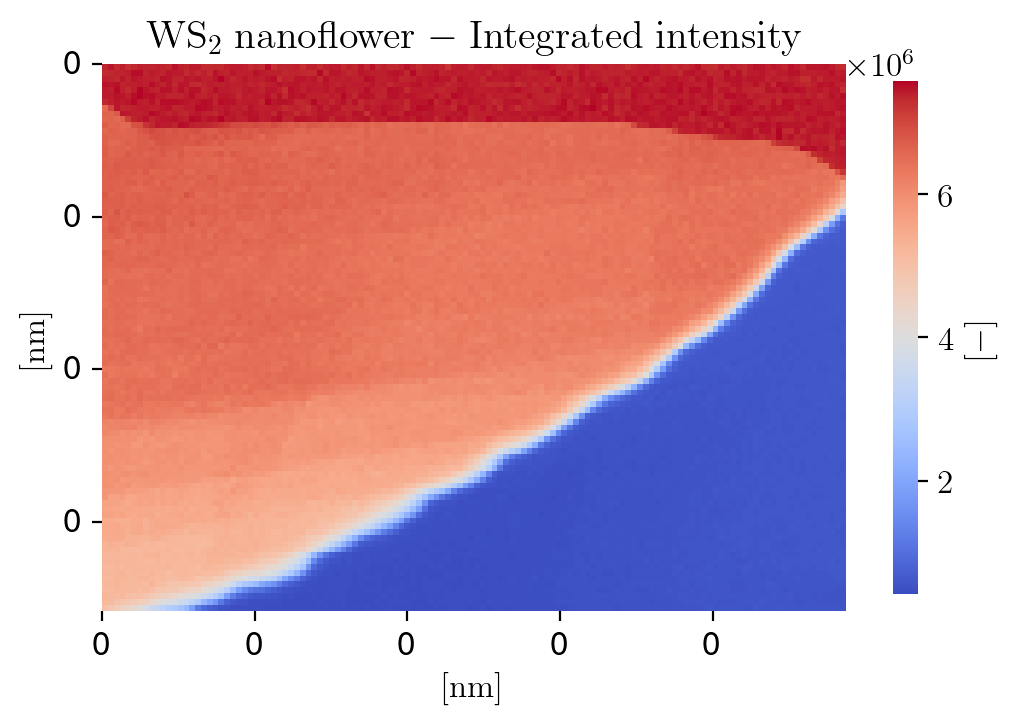

In [4]:
im.calc_axes()
intensity = np.sum(im.data, axis=2)
save_as = os.path.join(save_loc, "integrated_intensity.pdf")
fig = plot_heatmap(im, intensity, title = title_specimen + r'$\rm{-\;Integrated\;intensity\;}$',
                cbar_kws={'label': r'$\rm{[-]\;}$','shrink':cb_scale}, discrete_colormap = False,
                xlab = r'$\rm{[nm]\;}$', ylab = r'$\rm{[nm]\;}$', cmap = cmap,
                sig_ticks = sig_ticks, scale_ticks=scale_ticks, npix_xtick = npix_xtick, npix_ytick = npix_ytick, tick_int = tick_int,
                save_as = save_as)

## Clustering

Since the ZLP intensity depends strongly on the local thickness of the specimen, first of all we group individual spectra as a function of their thickness by means of unsupervised machine learning, specifically by means of the K-means clustering algorithm: 

In [8]:
n_clusters = 5
im.cluster(n_clusters)
im.set_n(4.1462, n_background = 1)   

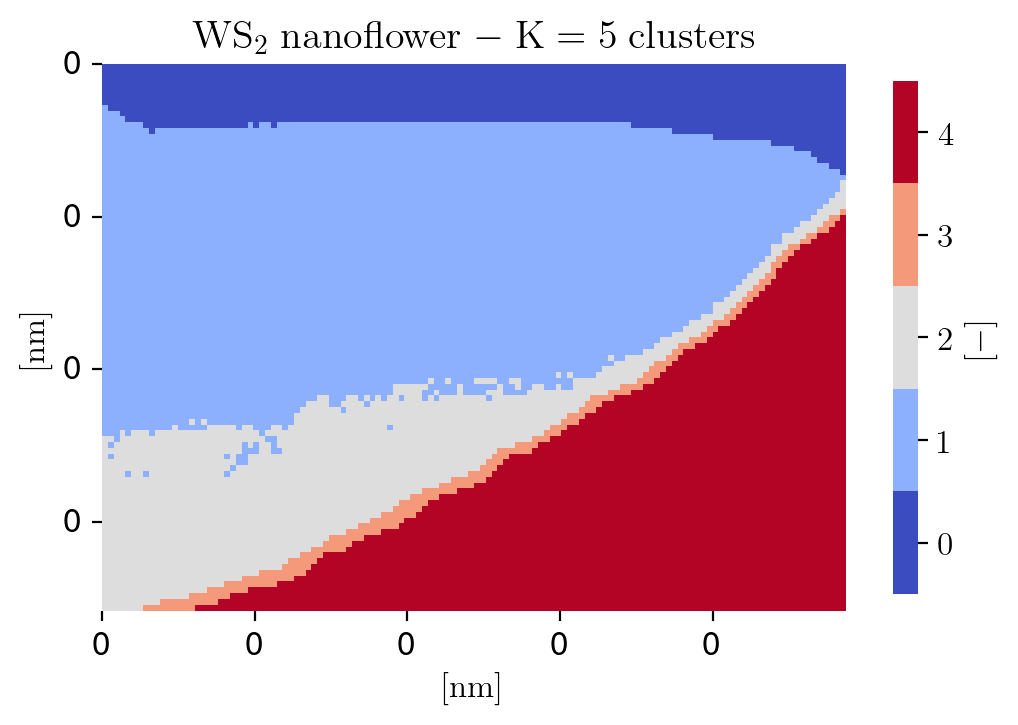

In [6]:
fig = plot_heatmap(im, im.clustered, title = title_specimen +  r'$\rm{-\;K=%d\;clusters\;}$' % n_clusters,
                cbar_kws={'label': r'$\rm{[-]\;}$','shrink':cb_scale}, discrete_colormap = True,
                xlab = r'$\rm{[nm]\;}$', ylab = r'$\rm{[nm]\;}$', cmap = cmap,
                sig_ticks = sig_ticks, scale_ticks = scale_ticks, npix_xtick = npix_xtick, npix_ytick = npix_ytick, tick_int = tick_int,
                save_as = save_loc + save_title_specimen + '_Clustered')

## Training of the ZLP

The ZLP can be trained with the following lines of code. It produces a couple of plots:
1.  The raw signal per cluster, including the position of the hyperparamter $E_I$
2.  The slow of the raw signal per cluster
3.  The value of the loss per epoch on both training and validation set

The more replicas one uses to train the ZLP, the more accurate the model becomes.

Plotting choice of dE1...
Plots stored in /Users/jaco/Documents/CBL-ML/EELS_KK/output
dE1 & dE2: [2.4   2.15  2.075 1.75  1.3  ] [7.20000011 6.4500001  6.22500009 5.25000008 3.90000006]
Started training on replica number 0, at time  2021-09-29 22:20:05.556830
Rep 0, Epoch 200, Training loss 685.33, Testing loss 1346.172
Rep 0, Epoch 400, Training loss 248.844, Testing loss 446.924
Rep 0, Epoch 600, Training loss 175.853, Testing loss 238.318
Rep 0, Epoch 800, Training loss 174.208, Testing loss 224.643
Rep 0, Epoch 1000, Training loss 173.342, Testing loss 223.135


<Figure size 720x648 with 0 Axes>

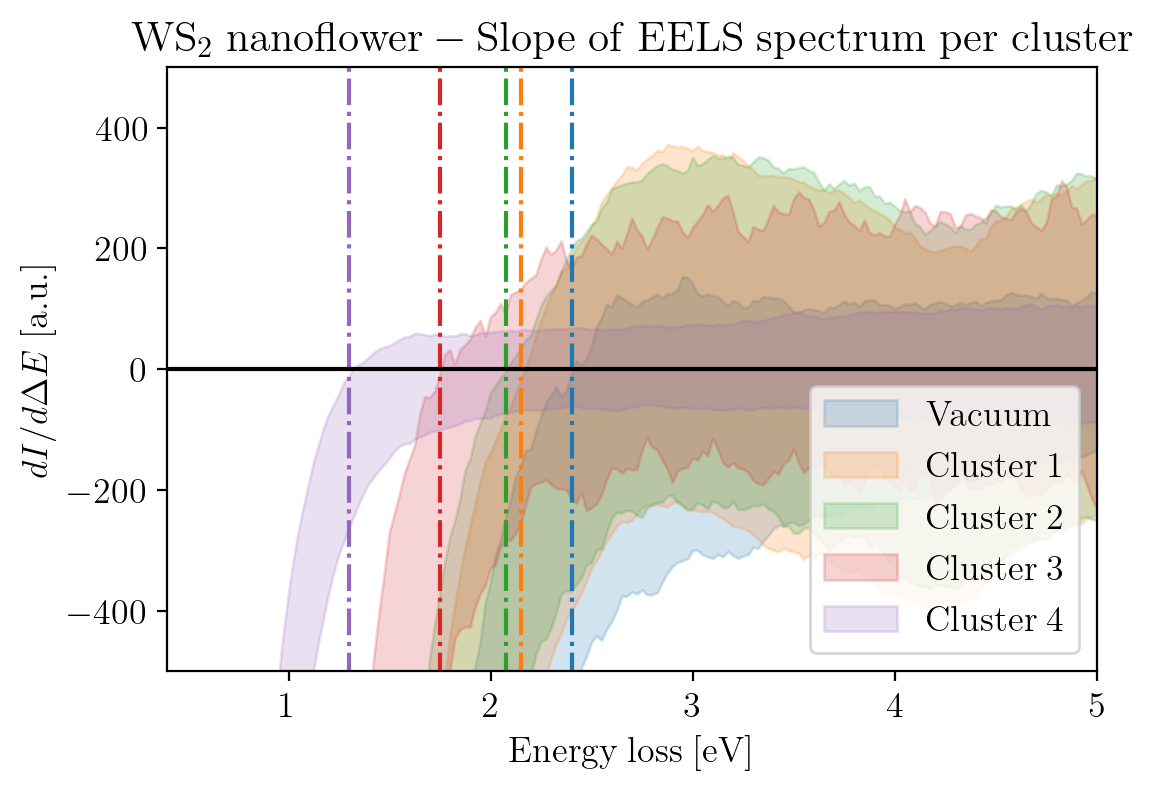

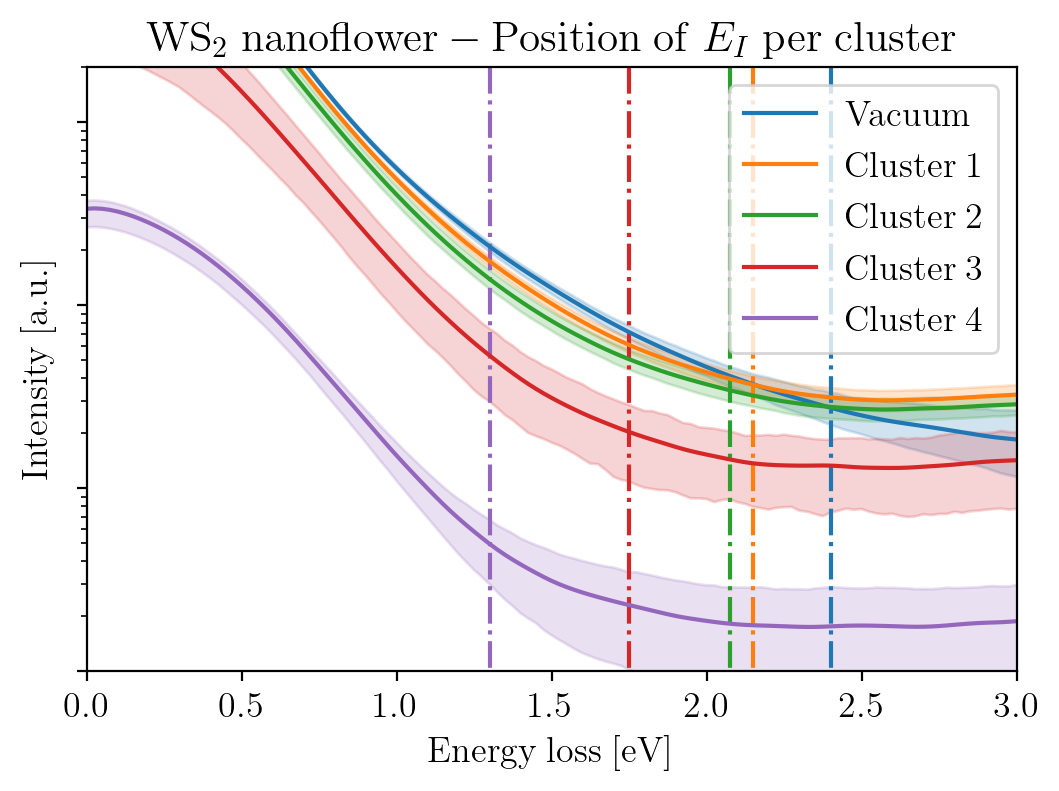

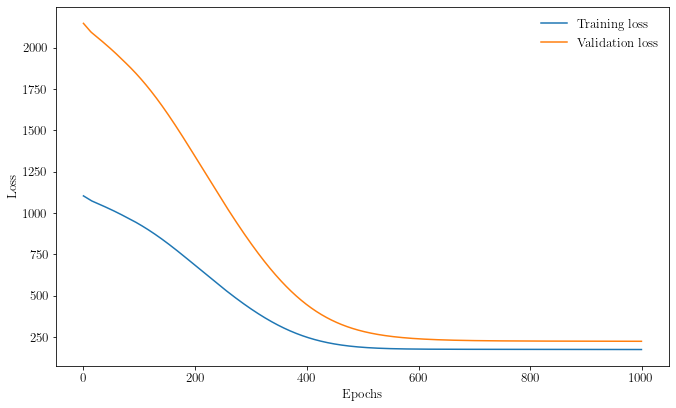

In [9]:
n_rep = 1  # number of replicas
n_epochs = 1000  # number of epochs
display_step = 200 # show training report after display_step steps
path_to_models = os.path.join(os.getcwd(), "models/tutorial") # where to store the trained models

if not os.path.exists(path_to_models):
    os.mkdir(path_to_models)

im.train_zlp(n_clusters=n_clusters,
            n_rep=n_rep,
            bs_rep_num=1,
            path_to_models=path_to_models,
            display_step=display_step,
            n_epochs=n_epochs,
            plot_de1=True,
            prob=True,
            perc_de1=16)

Since the actual training time that is needed to obtain a fair ammount of models (~5000) takes a couple of hourse, we provide a set of *pretrained* models to experiment with. We will use these in what follows. 

They can be downloaded by

In [ ]:
url = 'https://github.com/LHCfitNikhef/EELSfitter/blob/documentation/Models/tutorial/models_E1_p16_k5.zip?raw=true'
wget.download(url)

In [ ]:
!unzip models_E1_p16_k5.zip

In [10]:
path_to_pretrained_models = os.path.join(os.getcwd(), "models_E1_p16_k5")

## Training report

The pretaind models have now been downloaded, so let us see what they look like. The cell immediately below loads the models and plots the cost distribution on the training and validation sets.

chi2 plot saved at /Users/jaco/Documents/CBL-ML/EELS_KK/output


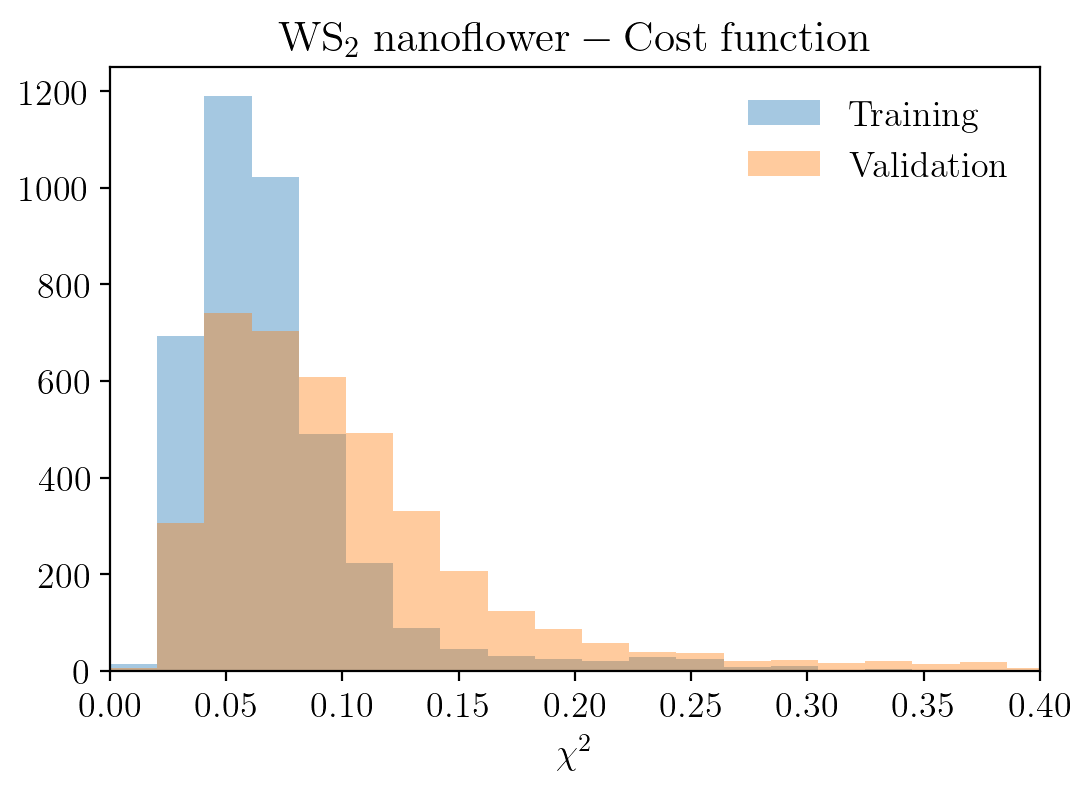

In [11]:
im.load_zlp_models(path_to_models=path_to_pretrained_models, title=r'$\rm{WS_2\;nanoflower-Cost\;function}$')

Besides the distribution of the costs, we can also plot how the predicted ZLPs behave as a function of the total integrated intensity per cluster:

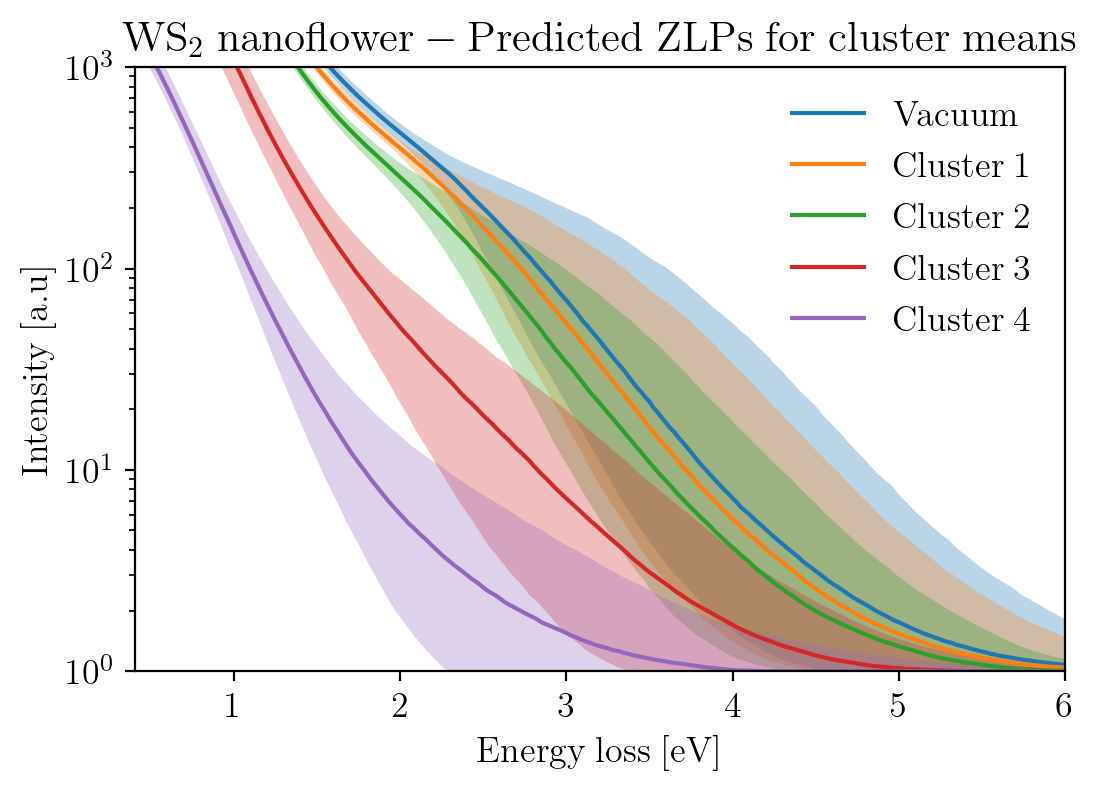

In [12]:
fig = ef.plotting.zlp.plot_zlp_ntot(im)

This shows that the clustering has been effective, since the ZLPs do not overlap before $E_I$. Let us consider a specific pixel, say (30, 90), to see how the subtacted spectrum compares to the raw spectrum.

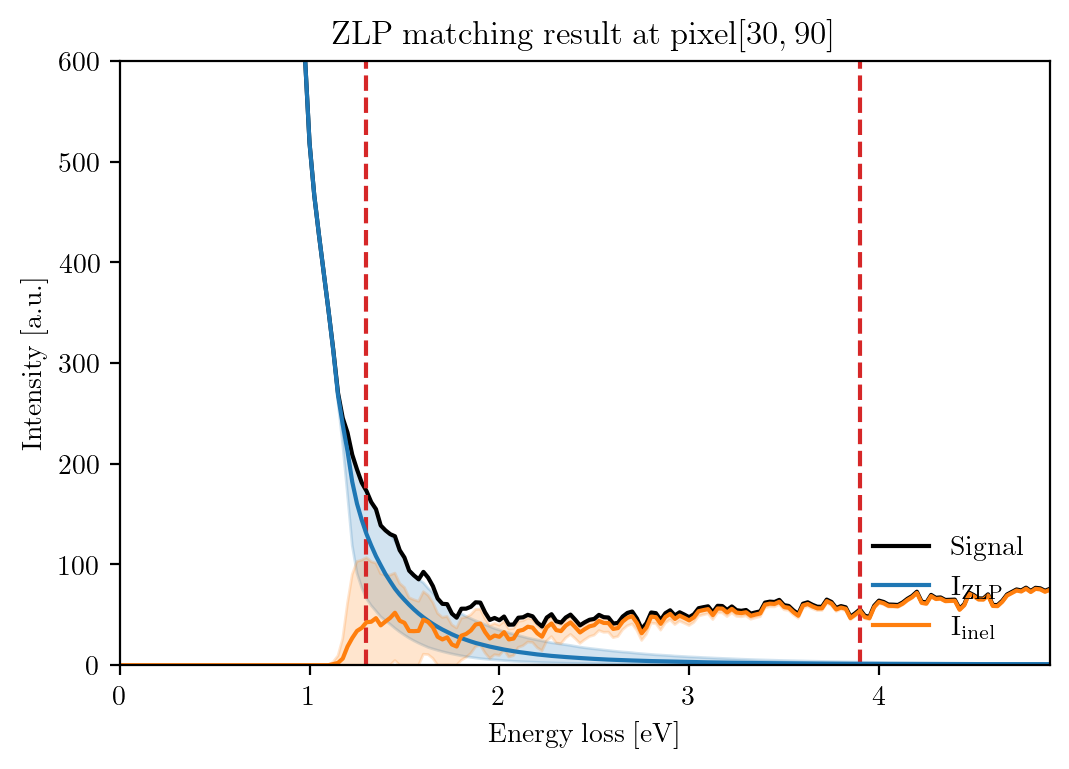

In [13]:
im.pool(5)
fig = ef.plotting.zlp.plot_inel_pred(im, 30, 90)

We conclude this tutorial by plotting, for each cluster, the raw signal plus the ZLP with uncertainties evaluated at the cluster means:

0
1
2
3
4


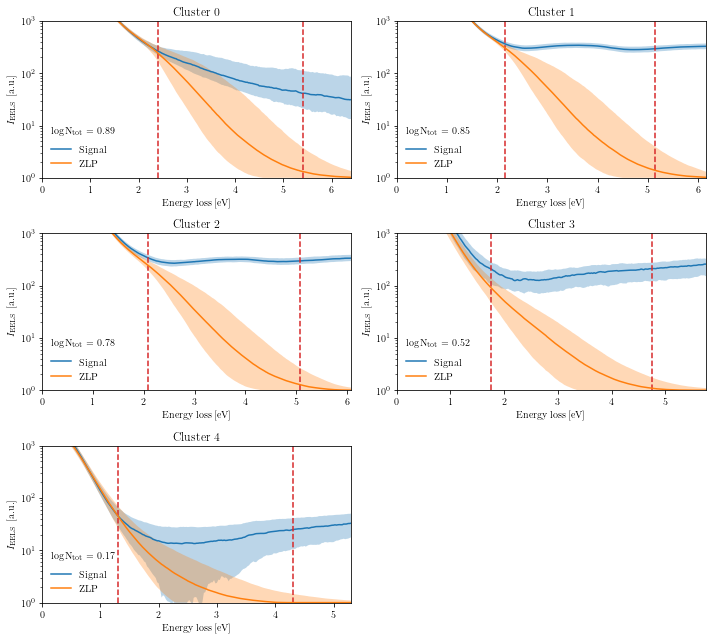

In [14]:
fig = plot_zlp_signal(im)